# Kaggle Housing Prices Predictions

## Imports and Custom Functions

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

# Deep Learning Imports
#Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Sci-kit Learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_columns',100)

# Supress Warnings, https://www.geeksforgeeks.org/how-to-disable-python-warnings/
import warnings
warnings.filterwarnings('ignore') 



In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


## Load and Check the Data

In [3]:
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum().sum()

6965

In [8]:
df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [9]:
#Find inconsistant categories of data
#Create index variable that contains all string columns in dataframe
string_cols = df.select_dtypes("object").columns
string_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
#Create loop that shows value counts for each string column in dataframe
for col in string_cols:
  print (f"Value Counts for {col}")
  print(df[col].value_counts())
  print ('\n') #For readability

Value Counts for MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


Value Counts for Street
Pave    1454
Grvl       6
Name: Street, dtype: int64


Value Counts for Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64


Value Counts for LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


Value Counts for LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


Value Counts for Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Value Counts for LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


Value Counts for LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


Value Counts for Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW    

### Split Data

In [11]:
# Define Target
target = 'SalePrice'

# Define X and y
y = df[target]
X = df.drop(columns = [target, 'Id'])
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,437,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
810,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1384,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Rec,204,Unf,0,356,560,GasA,TA,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1939.0,Unf,1,280,TA,TA,P,0,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
626,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,978,978,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1,286,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
813,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,TA,TA,CBlock,TA,TA,No,Rec,608,Unf,0,834,1442,GasA,Gd,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1958.0,RFn,1,301,TA,TA,Y,0,0,275,0,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


## Pre-Process the Data

In [13]:
# lists of columns for transformer
ord_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond'] #Electrical, BsmtFinType1, and BsmtFinType2 can be added with a diff encoder
num_cols = X_train.select_dtypes("number").columns
cat_cols = X_train.columns.drop(num_cols, ord_cols)


In [25]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA

# Impute missing values
impute_median = SimpleImputer(strategy = "median")
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)



# PREPROCESSING PIPELINE FOR ORDINAL DATA

# Impute missing values
impute_missing = SimpleImputer(strategy = "constant", fill_value = 'NA')
# Specifying the order of categories in quality/condition columns
qual_cond_order = ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']

# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order, qual_cond_order]
# Instantiate the ordinal encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Create the ordinal pipeline
ord_pipe = make_pipeline(impute_missing, ord_encoder)

ord_tuple = ("ordinal", ord_pipe, ord_cols)



# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_missing, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ("categorical", ohe_pipe, cat_cols)

# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],
                                    verbose_feature_names_out=False)
# Fit on training data
col_transformer.fit(X_train)

# Transform the training data
X_train_tf = col_transformer.transform(X_train)
# Transform the testing data
X_test_tf = col_transformer.transform(X_test)
# View the processed training data
X_train_tf.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,...,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1023,1.475911,-1.198986,-0.683950,0.637073,-0.515364,1.107889,1.020374,-0.519303,-0.944261,-0.284678,1.711873,0.642893,0.862092,-0.805280,-0.119821,-0.051643,-0.813995,-0.243017,0.772872,-0.766635,-1.112669,-0.207743,0.268177,0.591298,1.087084,0.293831,-0.192617,0.458853,-0.428838,-0.344584,-0.121808,-0.280154,-0.073333,-0.123489,-0.508139,0.137143,4.0,3.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
810,-0.871228,0.336917,-0.054883,-0.094926,0.390453,0.094543,0.682585,-0.023289,0.469362,2.166141,-1.279161,-0.046799,0.357895,-0.805280,-0.119821,-0.421692,1.119464,-0.243017,-1.062909,1.246471,0.128036,-0.207743,-0.963076,0.591298,-0.197370,0.293831,0.030695,1.295148,-0.718262,-0.344584,-0.121808,-0.280154,15.000378,-0.123489,-2.000860,-1.372124,3.0,3.0,3.0,3.0,2.0,4.0,2.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1384,-0.167086,-0.452976,-0.152524,-0.094926,-0.515364,-1.049557,-1.681937,-0.601000,-0.533502,-0.284678,-0.478553,-1.128667,-1.221922,0.465855,-0.119821,-0.518474,-0.813995,-0.243017,-1.062909,-0.766635,-1.112669,-0.207743,-0.347450,-0.961392,-1.647559,-1.069494,-0.938576,-0.738046,-0.718262,-0.344584,-0.121808,-0.280154,-0.073333,-0.123489,1.357763,0.891777,3.0,3.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
626,-0.871228,-0.014147,0.144198,-0.826925,-0.515364,-0.363097,-0.330782,-0.601000,-0.979219,-0.284678,0.920261,-0.186540,0.650071,-0.805280,-0.119821,-0.207253,-0.813995,-0.243017,-1.062909,-0.766635,0.128036,-0.207743,-0.347450,0.591298,-0.777445,-1.069494,-0.910068,-0.738046,-0.718262,0.242811,-0.121808,-0.280154,-0.073333,1.704639,0.611402,-0.617490,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
813,-0.871228,0.205268,-0.090142,-0.094926,0.390453,-0.428474,-1.295893,0.817019,0.349193,-0.284678,0.596420,0.859266,0.701784,-0.805280,-0.119821,-0.169300,-0.813995,-0.243017,-1.062909,1.246471,1.368742,-0.207743,0.268177,-0.961392,-0.860313,-1.069

## Deep Learning Models

In [28]:
# Step 1: Define our network structure
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape


309

### 1st Model

In [29]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(30, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(10, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
# Output layer
model.add(Dense(1, activation = 'linear'))

### Metrics are specified during the.compile step
# Step 2: Compile
model.compile(loss = 'mse', optimizer = 'adam',
               metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                9300      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,621
Trainable params: 9,621
Non-trainable params: 0
_________________________________________________________________


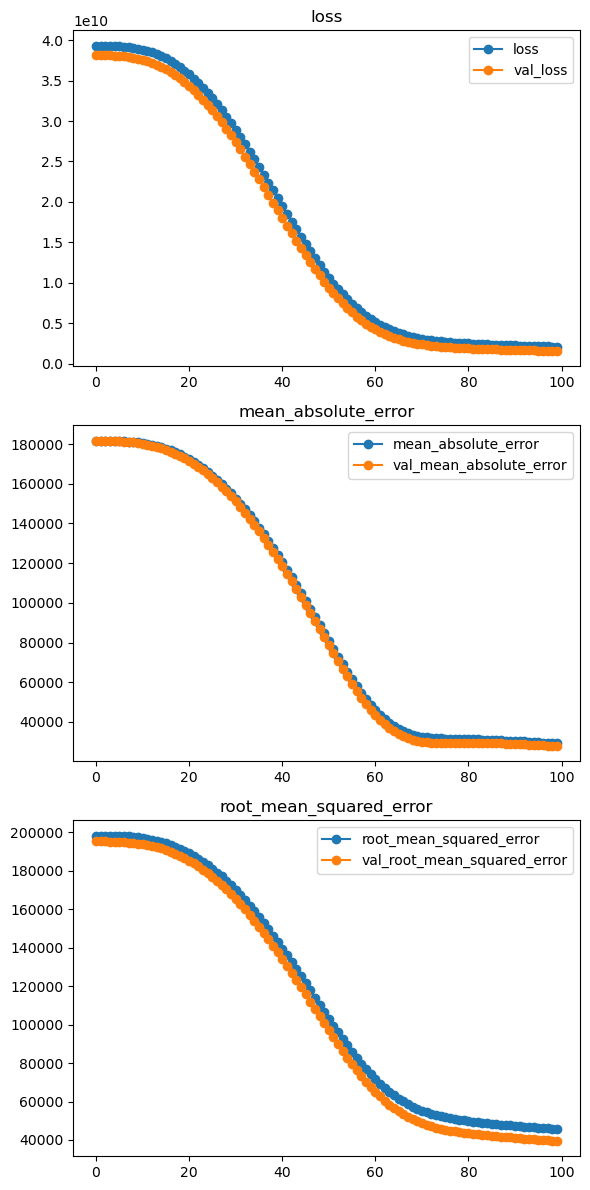

In [30]:
# Step 3: Fit our model
history = model.fit(X_train_tf, y_train,
                    validation_split=.2, 
                    epochs=100, verbose = 0)

plot_history(history);


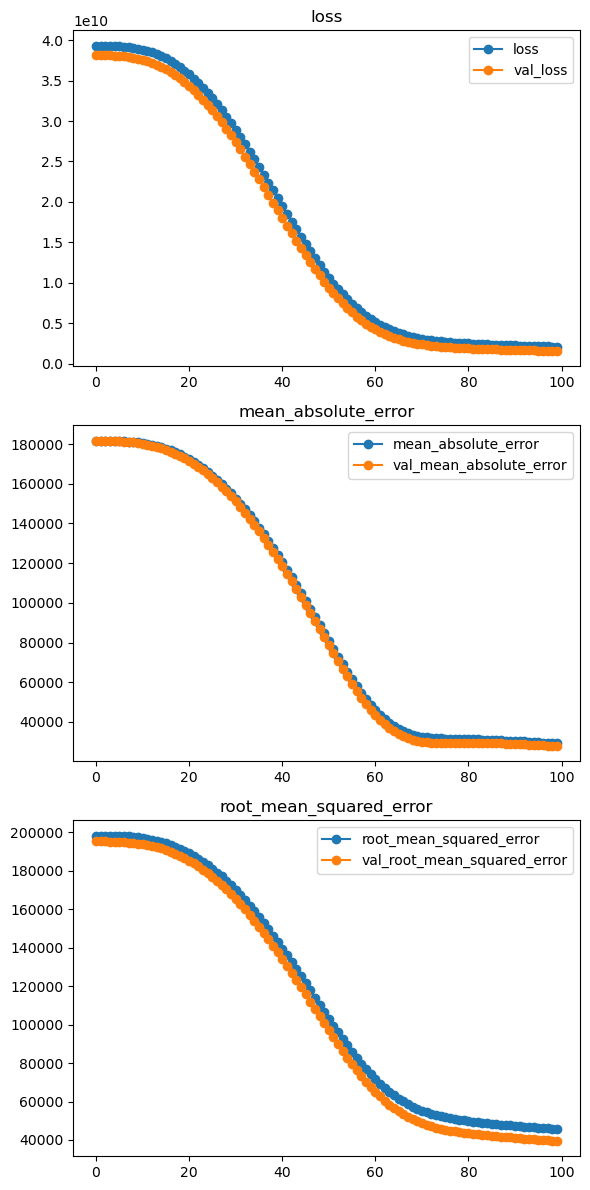

In [31]:
# Call the custom function
plot_history(history);


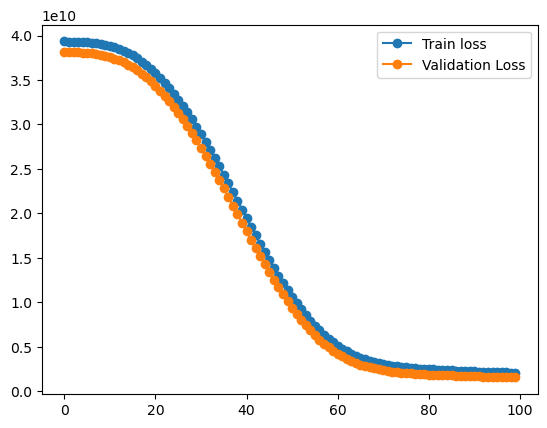

In [32]:
# Visualize the loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.legend();


In [33]:
# evaluate model
 
y_pred = model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 816us/step
final RMSE: 47859.583650364766
final MAE: 29391.763270547945
final R2: 0.6730280234501046


### 2nd Model

In [34]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(100, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(50, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
# Output layer
model.add(Dense(1, activation = 'linear'))

### Metrics are specified during the.compile step
# Step 2: Compile
model.compile(loss = 'mse', optimizer = 'adam',
               metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               31000     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 36,101
Trainable params: 36,101
Non-trainable params: 0
_________________________________________________________________


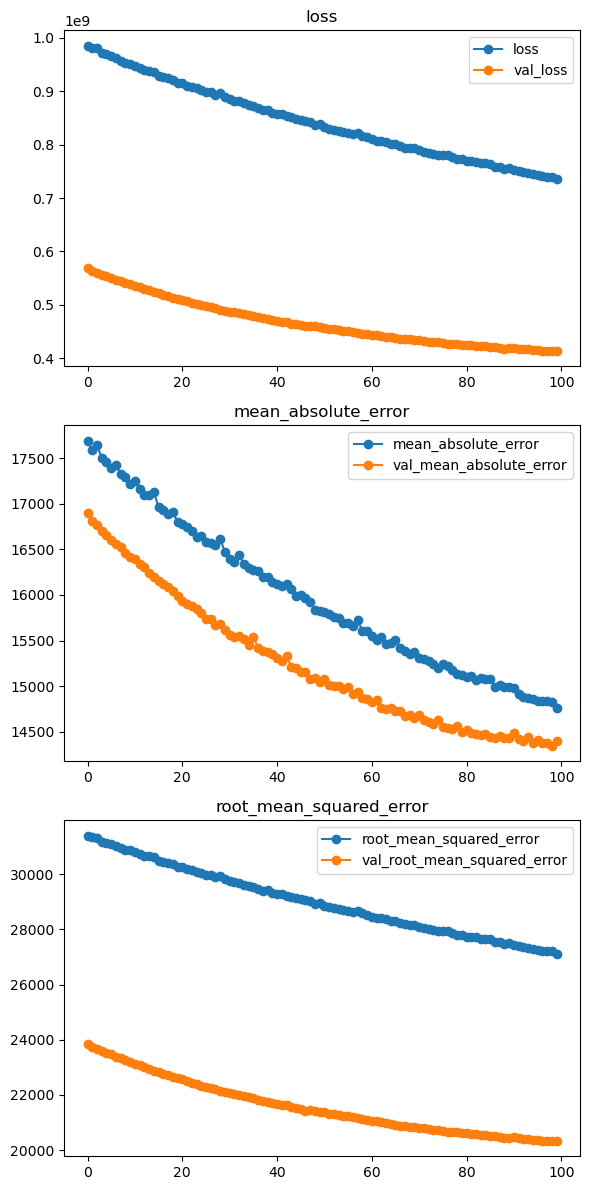

In [40]:
# Step 3: Fit our model
history = model.fit(X_train_tf, y_train,
                    validation_split=.2, 
                    epochs=100, verbose = 0)

plot_history(history);


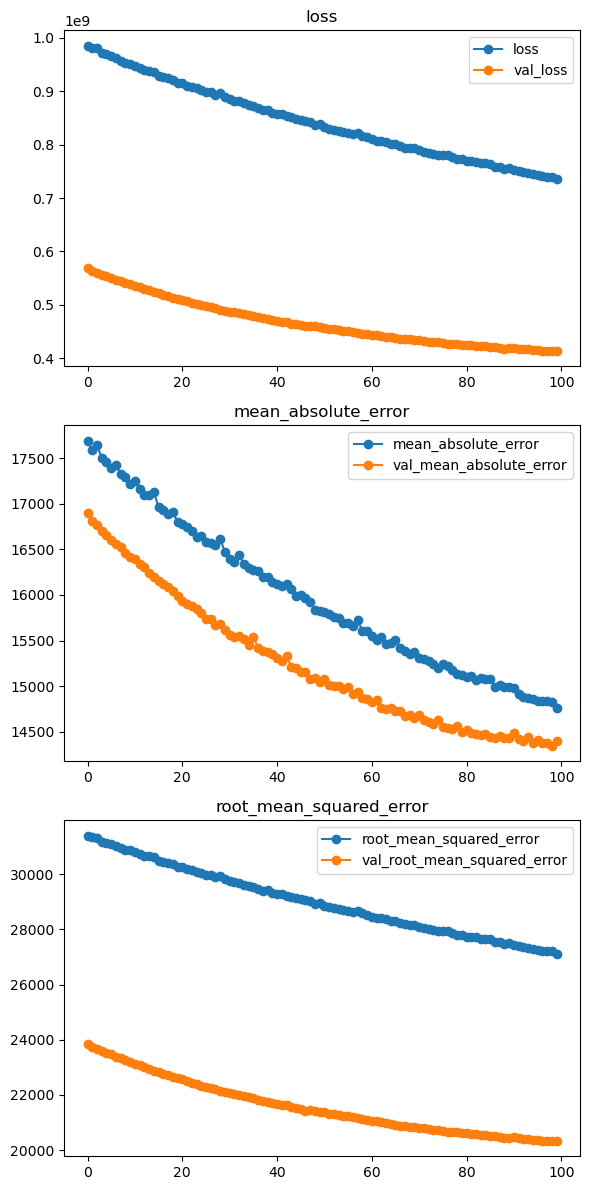

In [41]:
# Call the custom function
plot_history(history);


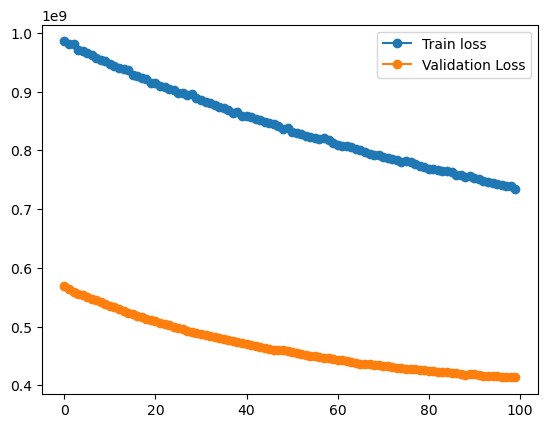

In [42]:
# Visualize the loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.legend();


In [43]:
# evaluate model
 
y_pred = model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 907us/step
final RMSE: 28622.553075354394
final MAE: 16889.7090432363
final R2: 0.8830529048139707


### 3rd Model

In [ ]:
#Add Dropout

In [50]:
# Sequential model
model = Sequential()

# First hidden layer
model.add(Dense(100, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(50, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
model.add(Dropout(.2))
# Output layer
model.add(Dense(1, activation = 'linear'))

### Metrics are specified during the.compile step
# Step 2: Compile
model.compile(loss = 'mse', optimizer = 'adam',
               metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               31000     
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 36,101
Trainable params: 36,101
Non-trainable params: 0
_________________________________________________________________


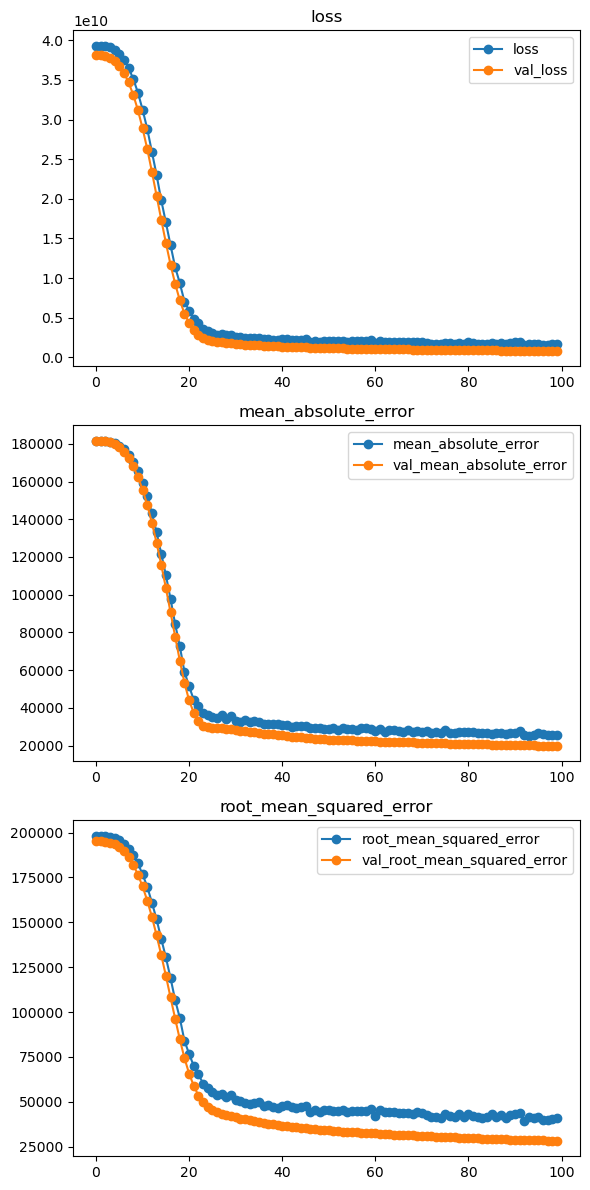

In [51]:
# Step 3: Fit our model
history = model.fit(X_train_tf, y_train,
                    validation_split=.2, 
                    epochs=100, verbose = 0)

plot_history(history);


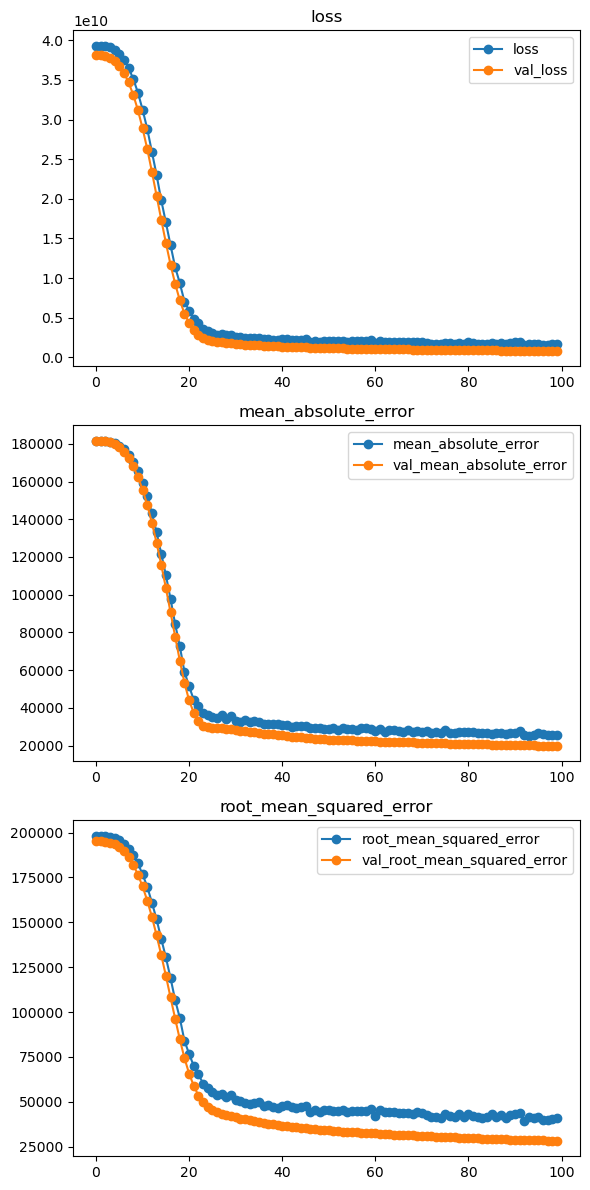

In [52]:
# Call the custom function
plot_history(history);


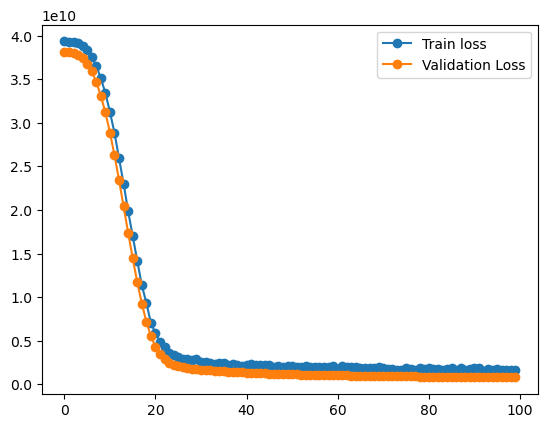

In [53]:
# Visualize the loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train loss', marker='o')
ax.plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax.legend();


In [54]:
# evaluate model
 
y_pred = model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 1ms/step
final RMSE: 35758.099649915814
final MAE: 21450.91114083904
final R2: 0.8174753346326205


### 4th Model

In [63]:
# Add hidden layers

In [64]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(80, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(40, 
                activation = 'relu'))
    model.add(Dense(20,
                    activation = 'relu'))
    model.add(Dense(10,
                    activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


In [65]:
# Call our build function to build model
reg_model3 = build_model()

# Get model summary
reg_model3.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 80)                24800     
                                                                 
 dense_26 (Dense)            (None, 40)                3240      
                                                                 
 dense_27 (Dense)            (None, 20)                820       
                                                                 
 dense_28 (Dense)            (None, 10)                210       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 29,081
Trainable params: 29,081
Non-trainable params: 0
_________________________________________________________________


In [66]:
history3 = reg_model3.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=100,
                        verbose=0)


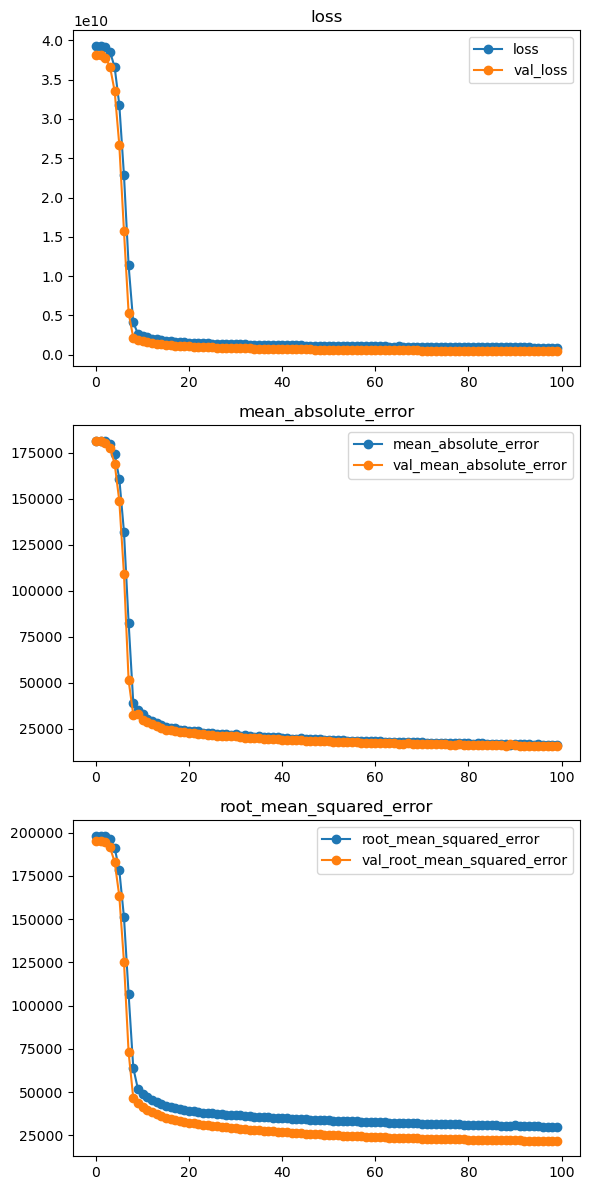

In [67]:
# plot learning 
plot_history(history3);


In [68]:
# evaluate model
 
y_pred = reg_model3.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 816us/step
final RMSE: 29967.903609379773
final MAE: 18117.10325342466
final R2: 0.8718007670994646


# Best Model Evaluation on Test Data

The 2nd and 4th models were my best models. 

My first model appeared to be underfit so to address bias I increased complexity first by adding nodes then by adding layers. This greatly improved the model. My 3rd model added dropout which slightly reduced the model's effectiveness, so I removed that for the 4th model.